In [995]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from ema_workbench import (
    ScalarOutcome,
    load_results,
    Policy,
    MultiprocessingEvaluator
)
from ema_workbench.analysis import parcoords
from ema_workbench.util import ema_logging, utilities

from sklearn.preprocessing import MinMaxScaler

from custom_problem_formulation_no_RfR import get_model_for_problem_formulation

In [996]:
# Load policies from the CSV file
policies_df = pd.read_csv('results/50_diverse_policies.csv')

# Drop unwanted columns
policies_df = policies_df.drop(columns=[
    'A.1_External Costs',
    'A.1_Expected Number of Deaths',
    'A.1_Expected Annual Damage',
    'A.2_External Costs',
    'A.2_Expected Number of Deaths',
    'A.2_Expected Annual Damage',
    'composite_ooi',
    'satisfied'
])

# Create a new column with the desired format
policies_df['index'] = 'scenario' + policies_df['scenario'].astype(str) + '_policy' + policies_df['Unnamed: 0'].astype(str)

# Set the new column as the index
policies_df.set_index('index', inplace=True)

# Drop the original 'scenario' and 'unnamed: 0' columns
policies_df = policies_df.drop(columns=['scenario', 'Unnamed: 0'])

policies_df


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
index,,,,,,,,,,,,,,,,,,,,,
scenario48226_policy61,0,0,0,0,1,1,1,1,1,1,...,0,5,5,1,7,0,4,0,6,7
scenario5666_policy117,0,0,1,0,0,0,1,1,1,1,...,0,4,4,0,5,0,4,5,0,0
scenario5666_policy138,0,0,0,1,0,0,1,1,1,1,...,0,5,7,7,6,2,7,4,0,5
scenario5666_policy143,1,0,0,0,0,0,1,1,1,1,...,0,5,5,6,4,5,8,7,0,3
scenario5666_policy132,0,0,0,0,1,0,1,1,1,1,...,0,1,2,5,6,9,0,3,7,1
scenario5666_policy91,0,1,0,0,1,0,1,1,1,1,...,0,6,4,10,7,5,6,0,6,5
scenario24626_policy72,1,0,0,0,0,0,1,1,1,1,...,0,6,3,0,6,5,7,6,4,4
scenario5666_policy150,0,0,1,0,1,0,1,1,1,1,...,0,4,1,5,6,0,1,4,6,5
scenario48226_policy3,1,0,1,0,0,0,1,1,1,1,...,0,4,5,6,3,5,0,5,6,6


In [997]:
# policies = []
# for idx, row in policies_df.iterrows():
#     policy_dict = row.to_dict()
#     policy_name = idx
#     policies.append(Policy(policy_name, **policy_dict))

model, steps = get_model_for_problem_formulation()

# # Define the number of scenarios
# n_scenarios = 1000

# # Perform experiments
# with MultiprocessingEvaluator(model) as evaluator:
#     results = evaluator.perform_experiments(n_scenarios,
#                                             policies)

# experiments, outcomes = results

In [998]:
# # Saving the results
# utilities.save_results(results, 'results/50_policies_1000_scenarios.tar.gz')

In [999]:
# Load the results
results = utilities.load_results('results/50_policies_1000_scenarios.tar.gz')

experiments, outcomes = results

outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
policies_50_results = outcomes.join(experiments)

In [1000]:
# Function to calculate SNR metric
def calculate_snr(policy, direction):
  mean_performance = np.mean(policy)
  std_dev = np.std(policy)
  
  if direction == ScalarOutcome.MINIMIZE:
      snr = mean_performance * std_dev
  else:
      snr = mean_performance / std_dev
  return snr


In [1001]:
# Initialize an empty list to store all SNR scores
snr_scores = []

# Iterate over each policy in the experiments DataFrame
for policy in experiments['policy'].unique():
    # Initialize a dictionary to store SNR scores for the current policy
    scores = {'policy': policy}
    
    # Filter experiments DataFrame to get rows where 'policy' matches the current policy
    logical = experiments['policy'] == policy
    
    # Iterate over each outcome in the model.outcomes list (replace with your actual outcomes)
    for outcome in model.outcomes:
        # Extract values from the experiments DataFrame where the logical condition is True
        value = outcomes[outcome.name][logical]
        
        # Calculate the signal-to-noise ratio (SNR) for the extracted values
        sn_ratio = calculate_snr(value, outcome.kind)
        
        # Store the SNR score in the scores dictionary with outcome name as key
        scores[outcome.name] = sn_ratio
    
    # Append the scores dictionary to the snr_scores list
    snr_scores.append(scores)

# Convert the list of dictionaries to a DataFrame
snr_scores_df = pd.DataFrame(snr_scores)

# Set policy column as
snr_scores_df.set_index('policy', inplace=True)

In [1002]:
snr_scores_df

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
policy,,,,,,
scenario48226_policy61,0.495516,0.000103,1.795914e+16,0.000000,4.458828e-07,3.533768e+13
scenario5666_policy117,0.277573,0.000626,1.024486e+17,0.000000,3.451979e-07,2.813842e+13
scenario5666_policy138,0.121798,0.000935,1.534418e+17,0.000000,3.764305e-07,3.038584e+13
scenario5666_policy143,1.061308,0.000262,4.394700e+16,0.000000,1.670880e-06,1.404912e+14
scenario5666_policy132,0.495516,0.000717,1.199669e+17,0.984149,7.692214e-08,5.935344e+12
scenario5666_policy91,0.000000,0.000448,7.424763e+16,0.984149,8.817097e-08,6.638484e+12
scenario24626_policy72,0.121798,0.001286,2.083302e+17,0.984149,5.234578e-08,4.200059e+12
scenario5666_policy150,0.121798,0.000241,4.038459e+16,0.000000,1.740643e-08,1.254401e+12
scenario48226_policy3,0.121798,0.000281,4.723850e+16,0.984149,8.956806e-08,6.733059e+12


It makes sense that for both A.1_External Costs and A.2_External Costs the snr ratio is 0 most of the times. This is due to the fact that we defined 'External Costs' as the sum of dike investment costs and evacuation costs. Both of these costs depend completely and mostly on policy levers respectively. Because the policy levers stay the same for all 1000 experiments that the policy is tested, it returns the same result every time, as a result of this the standard deviation is 0. Given the way the signal-to-noise ratio is calculated this will thus result in a value of 0 as well.

In [1003]:
#Creating a composite snr score so we can select the 20 best policies, we value each outcome of interest equally

scaler = MinMaxScaler()
normalized_snr = scaler.fit_transform(snr_scores_df[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 'A.1_External Costs',
                                                   'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths', 'A.2_External Costs']])
composite_snr = normalized_snr.sum(axis=1)
snr_scores_df['composite_snr'] = composite_snr 

# Dropping the 30 worst policies based on composite_snr score
snr_scores_df_top_20 = snr_scores_df.drop(snr_scores_df['composite_snr'].nlargest(30).index)

In [1004]:
snr_scores_df_top_20

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_snr
policy,,,,,,,
scenario48226_policy61,0.495516,0.000103,1.795914e+16,0.000000,4.458828e-07,3.533768e+13,0.256292
scenario5666_policy143,1.061308,0.000262,4.394700e+16,0.000000,1.670880e-06,1.404912e+14,0.766914
scenario5666_policy150,0.121798,0.000241,4.038459e+16,0.000000,1.740643e-08,1.254401e+12,0.337865
scenario48226_policy62,1.148879,0.000099,1.658653e+16,0.000000,4.444831e-07,3.524733e+13,0.462523
scenario48226_policy13,0.277573,0.000131,2.190856e+16,0.000000,1.735888e-06,1.454912e+14,0.292462
scenario5666_policy103,0.000000,0.000060,1.075026e+16,0.000000,1.762596e-06,1.474361e+14,0.087784
scenario48226_policy2,0.000000,0.000060,1.075026e+16,0.984149,9.594215e-08,7.198975e+12,0.816994
scenario48226_policy9,0.121798,0.000200,3.377231e+16,0.000000,4.389536e-07,3.487784e+13,0.292239
scenario48226_policy8,0.000000,0.000077,1.383416e+16,0.000000,1.758486e-06,1.471586e+14,0.117104


C:\Users\pepij\AppData\Local\Temp\ipykernel_79548\3726142043.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(snr_scores_df_top_20.index.unique()))


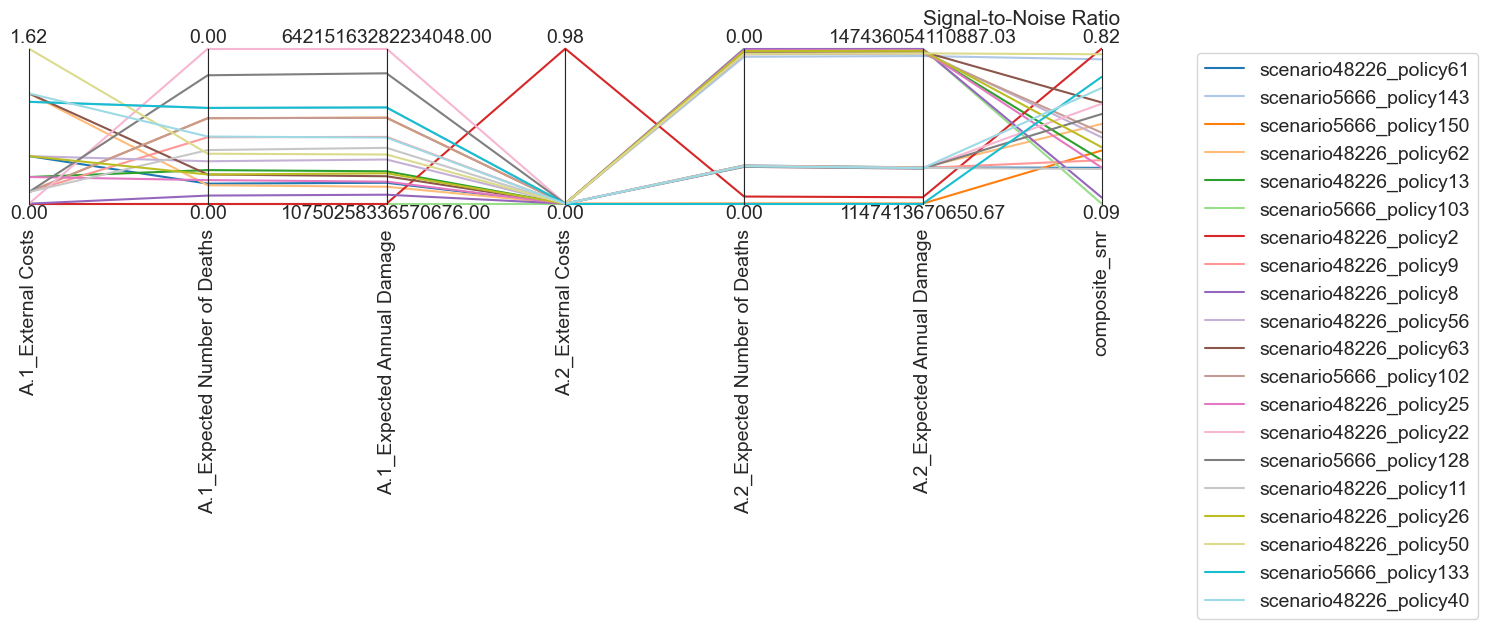

In [1005]:
import matplotlib.cm as cm

# Create a colormap
cmap = cm.get_cmap('tab20', len(snr_scores_df_top_20.index.unique()))

# Get the limits for the plot
limits = parcoords.get_limits(snr_scores_df_top_20)

# Create a parallel axes plot
paraxes = parcoords.ParallelAxes(limits)

for i, policy in enumerate(snr_scores_df_top_20.index.unique()):
    data = pd.DataFrame(snr_scores_df_top_20.loc[policy]).transpose()
    paraxes.plot(data, color=cmap(i), label=policy)

paraxes.legend()
fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.title('Signal-to-Noise Ratio', loc='left', fontsize=15)
# plt.savefig('images/snr_top20.png')
plt.show()

In [1006]:
# Twee policies die eruit springen zijn: 
snr_scores_df_top_20.sort_values(by='composite_snr', ascending=True).head(2)

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_snr
policy,,,,,,,
scenario5666_policy103,0.0,0.000060,1.075026e+16,0.0,0.000002,1.474361e+14,0.087784
scenario48226_policy8,0.0,0.000077,1.383416e+16,0.0,0.000002,1.471586e+14,0.117104


In [1007]:
# Minste regret voor deaths 

### Max Regret

In [1008]:
# Define a function to extract the scenario_original
def extract_scenario(policy):
    return policy.split('_')[0][8:]

# Apply the function to create the new column
policies_50_results['scenario_original'] = policies_50_results['policy'].apply(lambda x: extract_scenario(x))

In [1009]:
# Get unique values in 'policy' column
unique_scenarios = policies_50_results['scenario_original'].unique()
print("Unique scenarios:", unique_scenarios)

# Create a dictionary of DataFrames, each keyed by unique scenario value
scenario_dfs = {scenario: policies_50_results[policies_50_results['scenario_original'] == scenario] \
                .reset_index(drop=True) for scenario in unique_scenarios}

df_scenario_14779 = scenario_dfs['14779']
print("DataFrame for scenario 14779:")
display(df_scenario_14779)

# Do the same for the other scenarios
df_scenario_48226 = scenario_dfs['48226']
df_scenario_5666 = scenario_dfs['5666']
df_scenario_24626 = scenario_dfs['24626']

Unique scenarios: ['48226' '5666' '24626' '14779']
DataFrame for scenario 14779:


,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,scenario_original
0,0.0,0.000000,0.000000e+00,4.281842e+07,0.001466,1.054307e+07,9,139.253259,1.0,0.464855,...,7,7,7,4,0,5,0,scenario14779_policy0,dikesnet,14779
1,0.0,0.000000,0.000000e+00,4.281842e+07,0.002667,2.707169e+07,112,53.817150,1.0,0.474104,...,7,7,7,4,0,5,1,scenario14779_policy0,dikesnet,14779
2,0.0,0.000000,0.000000e+00,4.281842e+07,0.000422,3.043056e+06,61,262.051872,1.5,0.723887,...,7,7,7,4,0,5,2,scenario14779_policy0,dikesnet,14779
3,0.0,0.000000,0.000000e+00,4.281842e+07,0.000428,4.127193e+06,125,339.482608,1.0,0.443352,...,7,7,7,4,0,5,3,scenario14779_policy0,dikesnet,14779
4,0.0,0.000000,0.000000e+00,4.281842e+07,0.029864,2.567761e+08,25,168.798845,10.0,0.774779,...,7,7,7,4,0,5,4,scenario14779_policy0,dikesnet,14779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.000000,0.000000e+00,4.281842e+07,0.000419,3.652869e+06,85,57.244733,1.5,0.160069,...,7,7,7,4,0,5,995,scenario14779_policy0,dikesnet,14779
996,0.0,0.000000,0.000000e+00,4.281842e+07,0.012059,1.046155e+08,110,151.780575,1.5,0.671273,...,7,7,7,4,0,5,996,scenario14779_policy0,dikesnet,14779
997,0.0,0.164613,2.680982e+09,4.281842e+07,0.000000,0.000000e+00,50,126.794468,1.0,0.007401,...,7,7,7,4,0,5,997,scenario14779_policy0,dikesnet,14779
998,0.0,0.000000,0.000000e+00,4.281842e+07,0.042290,5.116366e+08,121,43.388625,1.5,0.977557,...,7,7,7,4,0,5,998,scenario14779_policy0,dikesnet,14779


In [1010]:
# Define the outcomes of interest
outcomes_of_interest = ['A.1_External Costs',
 'A.1_Expected Number of Deaths',
 'A.1_Expected Annual Damage',
 'A.2_External Costs',
 'A.2_Expected Number of Deaths',
 'A.2_Expected Annual Damage'
 ]

# Create a list of all remaining policies
remaining_policies = snr_scores_df_top_20.index.unique().to_list()
print('Remaining policies: ', remaining_policies), print('len: ', len(remaining_policies))

# Create a set to store the unique scenario values
setje = set()
for item in remaining_policies:
    setje.add(item.split('_')[0])
print(setje)

Remaining policies:  ['scenario48226_policy61', 'scenario5666_policy143', 'scenario5666_policy150', 'scenario48226_policy62', 'scenario48226_policy13', 'scenario5666_policy103', 'scenario48226_policy2', 'scenario48226_policy9', 'scenario48226_policy8', 'scenario48226_policy56', 'scenario48226_policy63', 'scenario5666_policy102', 'scenario48226_policy25', 'scenario48226_policy22', 'scenario5666_policy128', 'scenario48226_policy11', 'scenario48226_policy26', 'scenario48226_policy50', 'scenario5666_policy133', 'scenario48226_policy40']
len:  20
{'scenario48226', 'scenario5666'}


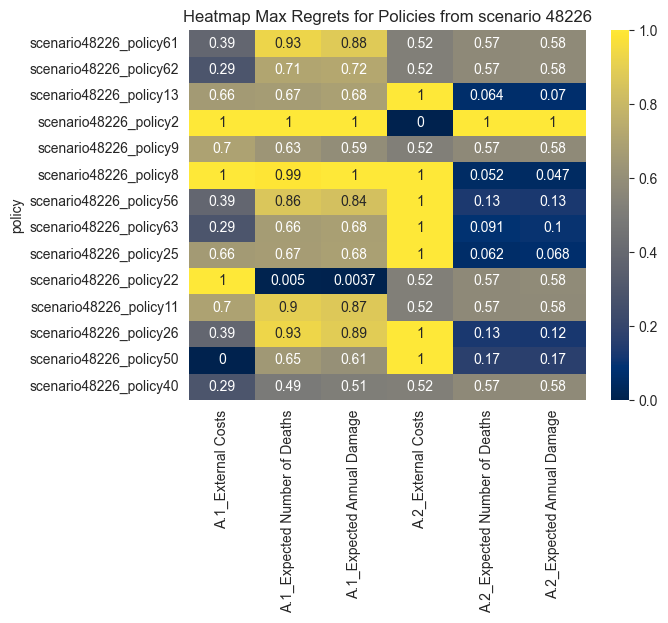

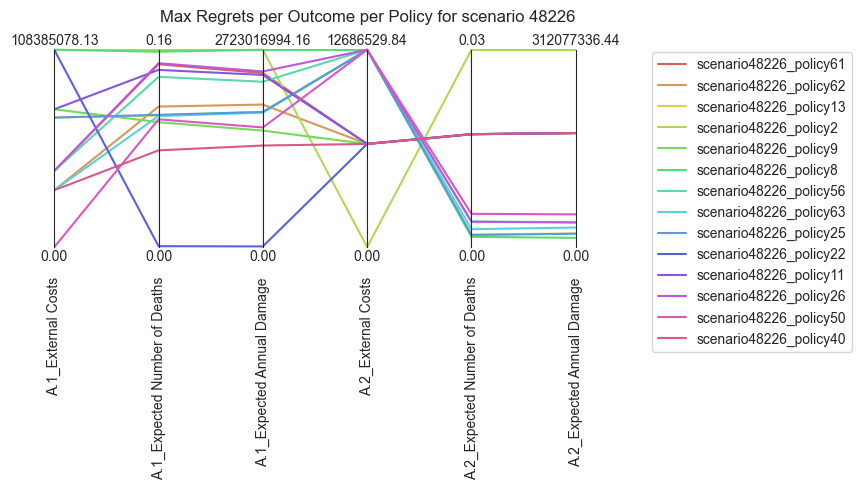

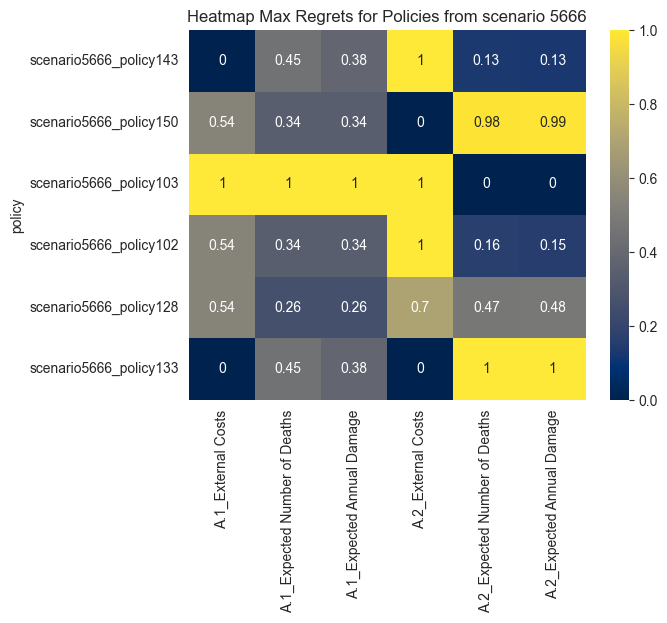

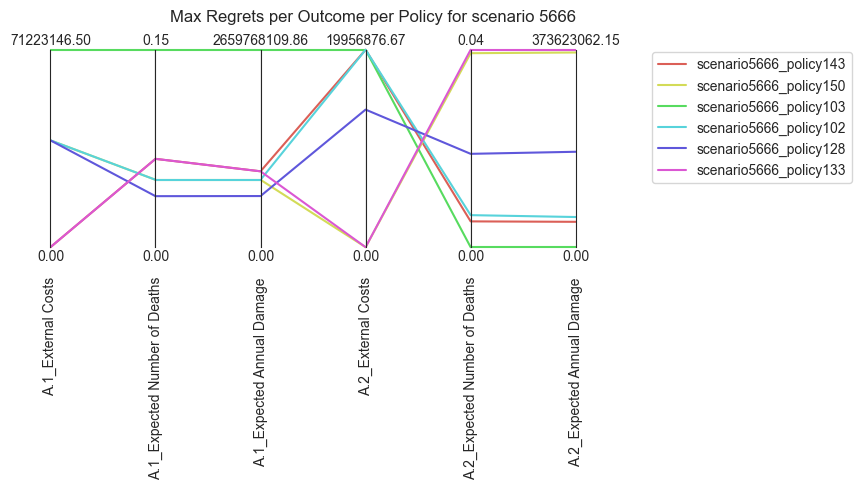

In [1011]:
# List of all scenario's dataframes, based on the set of unique scenario values defined above
all_scenario_df = [df_scenario_48226, df_scenario_5666] 

# Loop over all scenarios df's
for df_scenario in all_scenario_df:
    
    # Create dictionaries to store the maximum regret for each outcome and all regrets
    max_regret = dict()
    all_regrets = dict()
    
    # Loop over all outcomes of interest
    for outcome in outcomes_of_interest:

        # Select the relevant data
        data = df_scenario[[outcome, 'policy', 'scenario']]

        # Only keep remaining policies as found by the snr analysis
        data = data[data['policy'].isin(remaining_policies)]
        
        # Reorient the data by indexing with policy and scenario id
        data = data.pivot(index='scenario', columns='policy')
       
        # Flatten the column index         
        data.columns = data.columns.get_level_values(1)
        
        # Calculate the regret for each outcome
        outcome_regret = np.abs(data.sub(data.max(axis=1), axis=0))

        # Store the regret values in the dictionaries    
        all_regrets[outcome] = outcome_regret
        max_regret[outcome] = outcome_regret.max()

    # max_regret in a DataFrame
    max_regret = pd.DataFrame(data=max_regret)

    # Normalize the max_regret
    normalized_max_regret = max_regret/max_regret.max()

    # Save the scenario string for the title
    scenario_string = str(df_scenario['scenario_original'][0])

    # Plot the heatmap
    sns.heatmap(normalized_max_regret, cmap='cividis', annot=True)
    plt.title(f'Heatmap Max Regrets for Policies from scenario {scenario_string}')
    # plt.savefig('images/regret_' + scenario_string + '_heatmap.png')
    plt.show()

    # Data for the parallel plot (not normalized)
    data = max_regret

    # Get the limits for the parallel plot
    limits = parcoords.get_limits(data)
    # Set first row to 0, so we can see the lines better
    limits.loc[0, :] = 0
    
    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        colors = sns.color_palette('hls', data.shape[0])
        temp_df = pd.DataFrame(row).transpose()
        paraxes.plot(temp_df, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Max Regrets per Outcome per Policy for scenario {scenario_string}', loc='right')
    # plt.savefig('images/max_regret_' + scenario_string + '_parallel_plot.png')
        
    plt.show()

In [1028]:
snr_scores_df_top_20.sort_values(by='composite_snr', ascending=True).head()

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_snr
policy,,,,,,,
scenario5666_policy103,0.000000,0.000060,1.075026e+16,0.0,1.762596e-06,1.474361e+14,0.087784
scenario48226_policy8,0.000000,0.000077,1.383416e+16,0.0,1.758486e-06,1.471586e+14,0.117104
scenario48226_policy11,0.121798,0.000173,3.000411e+16,0.0,4.399750e-07,3.488309e+13,0.251095
scenario48226_policy61,0.495516,0.000103,1.795914e+16,0.0,4.458828e-07,3.533768e+13,0.256292
scenario48226_policy25,0.277573,0.000110,1.833555e+16,0.0,1.744054e-06,1.460221e+14,0.257523


In [1036]:
# Best composite_snr score
policies_to_keep = list()
for i in snr_scores_df_top_20.sort_values(by='composite_snr', ascending=True).head(2).index:
    policies_to_keep.append(i)

policies_to_keep.append('scenario48226_policy2')
policies_to_keep.append('scenario48226_policy11')
policies_to_keep.append('scenario5666_policy133')
policies_to_keep

['scenario5666_policy103',
 'scenario48226_policy8',
 'scenario48226_policy2',
 'scenario48226_policy11',
 'scenario5666_policy133']

scenario48226_policy2 (low snr score,  
scenario48226_policy11 (scores very decent on all, is not dominated)  
scenario48226_policy8 (scores very high on first outcomes, is not dominated)  
  
scenario5666_policy103 (low snr score,   
scenario5666_policy133 (dominates 150, and only other one which scores high on last two outcomes)  


In [1073]:
interested_levers = ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2'
]

final_policies = policies_to_keep.copy()
levers_dict = dict()
for policy in final_policies:
    
    levers = experiments[experiments['policy'] == policy].iloc[0].to_dict()
    levers_dict[policy] = levers
df_interested_levers_final_policies = pd.DataFrame(data=levers_dict).transpose()[interested_levers]
df_interested_levers_final_policies
# experiments[experiments['policy'] == 'scenario48226_policy2'].nunique()


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
scenario5666_policy103,0,1,1,0,1,0,1,1,1,1,...,0,1,1,3,2,1,6,4,5,2
scenario48226_policy8,1,0,0,1,1,0,1,1,1,1,...,0,0,2,5,5,5,3,5,1,4
scenario48226_policy2,1,1,0,0,1,0,1,1,1,1,...,0,5,2,2,3,6,5,1,1,4
scenario48226_policy11,1,0,0,0,1,0,1,1,1,1,...,0,6,1,6,5,4,3,5,1,6
scenario5666_policy133,0,0,1,0,0,0,1,1,1,1,...,0,4,3,3,4,5,7,3,5,7


Dit is einde notebook. Tenzij we nog wat willen laten zien. Cellen er onder staan in principe klaar voor gebruik.

In [1066]:
experiments[experiments['policy'] == policy].loc[0:1, 'A.3_DikeIncrease 0': 'A.3_DikeIncrease 2']

,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2


In [1068]:
remaining_levers.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.0_ID flood wave shape', 'A.1_Bmax',
       'A.1_Brate', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate',
       'A.2_DikeIncrease 0', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_DikeIncrease 0',
       'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'A.5_pfail', 'EWS_DaysToThreat',
       'discount rate 0', 'discount rate 1', 'discount rate 2'],
      dtype='object')

In [1014]:
remaining_levers = pd.DataFrame()

for policy in remaining_policies:
    # Filter rows for the current policy
    df = policy_levers[policy_levers['policy'] == policy]
    
    # Filter out columns where all values are zero
    nonzero_columns = df.columns[(df != 0).any()]
    df = df[nonzero_columns]
    
    # Take the first row (iloc[0]) of the filtered dataframe
    df = df.head(1)
    
    # Concatenate the filtered dataframe with remaining_levers
    remaining_levers = pd.concat([remaining_levers, df])

remaining_levers = remaining_levers.reindex(sorted(remaining_levers.columns), axis=1)
remaining_levers.set_index('policy', inplace=True)
remaining_levers

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_Bmax,A.5_Brate,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_pfail,EWS_DaysToThreat,discount rate 0,discount rate 1,discount rate 2
policy,,,,,,,,,,,,,,,,,,,,,
scenario48226_policy61,NaN,NaN,NaN,NaN,1.0,1.0,1,1,1,1,...,206.280768,1.5,NaN,6.0,7.0,0.874748,3,3.5,3.5,3.5
scenario5666_policy143,1.0,NaN,NaN,NaN,NaN,NaN,1,1,1,1,...,206.280768,1.5,7.0,NaN,3.0,0.874748,4,3.5,3.5,3.5
scenario5666_policy150,NaN,NaN,1.0,NaN,1.0,NaN,1,1,1,1,...,206.280768,1.5,4.0,6.0,5.0,0.874748,3,3.5,3.5,3.5
scenario48226_policy62,NaN,1.0,NaN,NaN,NaN,NaN,1,1,1,1,...,206.280768,1.5,NaN,5.0,6.0,0.874748,3,3.5,3.5,3.5
scenario48226_policy13,NaN,NaN,1.0,NaN,NaN,1.0,1,1,1,1,...,206.280768,1.5,6.0,5.0,NaN,0.874748,3,3.5,3.5,3.5
scenario5666_policy103,NaN,1.0,1.0,NaN,1.0,NaN,1,1,1,1,...,206.280768,1.5,4.0,5.0,2.0,0.874748,3,3.5,3.5,3.5
scenario48226_policy2,1.0,1.0,NaN,NaN,1.0,NaN,1,1,1,1,...,206.280768,1.5,1.0,1.0,4.0,0.874748,3,3.5,3.5,3.5
scenario48226_policy9,NaN,1.0,1.0,NaN,NaN,NaN,1,1,1,1,...,206.280768,1.5,6.0,7.0,7.0,0.874748,3,3.5,3.5,3.5
scenario48226_policy8,1.0,NaN,NaN,1.0,1.0,NaN,1,1,1,1,...,206.280768,1.5,5.0,1.0,4.0,0.874748,3,3.5,3.5,3.5


In [1015]:
levers = experiments.columns.to_list()
levers = levers[0:-3]
policy_levers = experiments.loc[:, levers]
policy_levers['policy'] = experiments['policy']
policy_levers.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,policy
0,9,139.253259,1.0,0.464855,151.322344,1.0,0.265613,124.745485,10.0,0.776687,...,5,5,1,7,0,4,0,6,7,scenario48226_policy61
1,112,53.817150,1.0,0.474104,307.257445,1.0,0.300343,248.101172,1.0,0.657379,...,5,5,1,7,0,4,0,6,7,scenario48226_policy61
2,61,262.051872,1.5,0.723887,230.548800,1.5,0.509309,290.479107,1.0,0.002462,...,5,5,1,7,0,4,0,6,7,scenario48226_policy61
3,125,339.482608,1.0,0.443352,50.784994,1.0,0.576845,275.882906,10.0,0.260456,...,5,5,1,7,0,4,0,6,7,scenario48226_policy61
4,25,168.798845,10.0,0.774779,97.138712,10.0,0.037512,81.941086,1.0,0.191117,...,5,5,1,7,0,4,0,6,7,scenario48226_policy61


In [1016]:
# filter policies out, (DIT DUS NOG EVEN AANPASSEN EN KIEZEN)
drop_list = ['scenario48226_policy63',
    'scenario48226_policy56',
    'scenario48226_policy26',
    'scenario48226_policy11',
    'scenario48226_policy9',

    'scenario5666_policy143',
    'scenario5666_policy150',
    'scenario5666_policy128'
]

for policy in drop_list:
    df_final = snr_scores_df_top_20.copy()
    df_final = df_final.drop([policy])

remaining_policies = snr_scores_df_top_20.index.unique().to_list()

SNR plotting, 

C:\Users\pepij\AppData\Local\Temp\ipykernel_79548\4000733818.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(df_final.index.unique()))


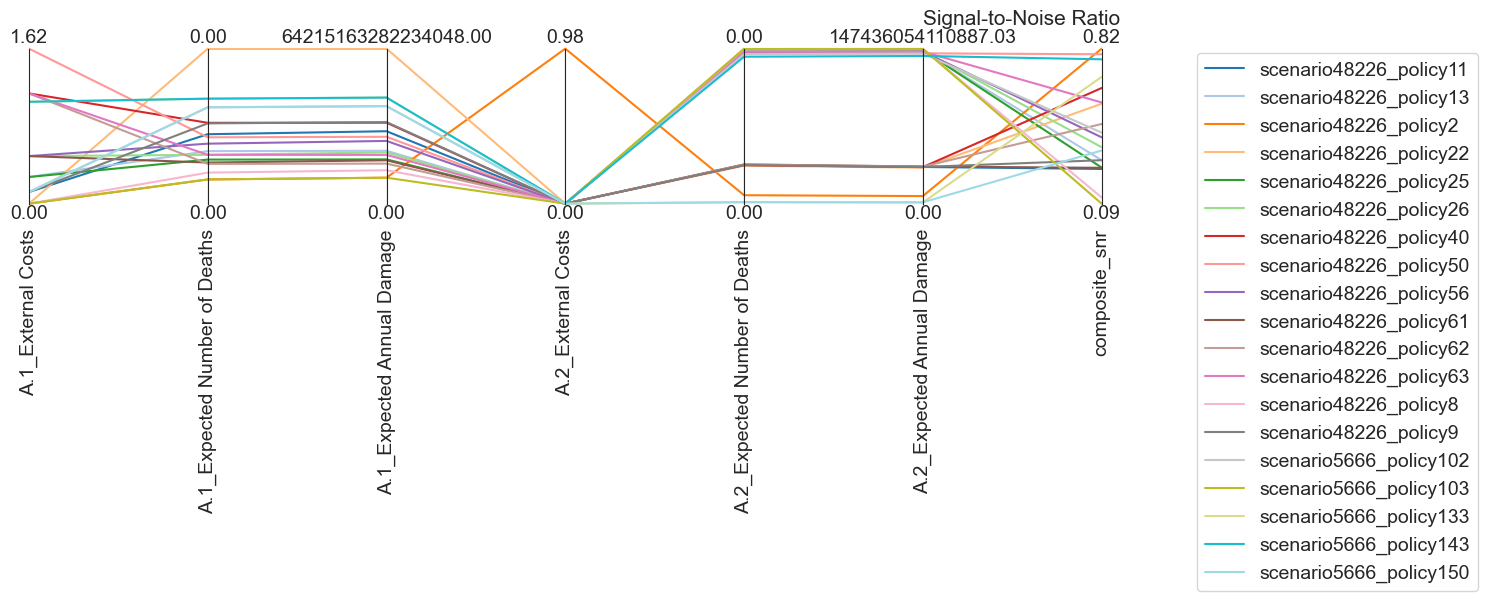

In [1017]:
import matplotlib.cm as cm

# Create a colormap
cmap = cm.get_cmap('tab20', len(df_final.index.unique()))

# Get the limits for the plot
limits = parcoords.get_limits(df_final)
limits.loc[0, outcomes_of_interest]  = 0
for outcome in outcomes_of_interest:
    limits.loc[1, outcome] = df_final[outcome].max()

# Sort the DataFrame by index
df_final = df_final.sort_index()
# Create a parallel axes plot
paraxes = parcoords.ParallelAxes(limits)

for i, policy in enumerate(df_final.index.unique()):
    data = pd.DataFrame(df_final.loc[policy]).transpose()
    paraxes.plot(data, color=cmap(i), label=policy)

paraxes.legend()
fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.title('Signal-to-Noise Ratio', loc='left', fontsize=15)
# plt.savefig('images/snr_top20.png')
plt.show()

In [1018]:
remaining_policies

['scenario48226_policy61',
 'scenario5666_policy143',
 'scenario5666_policy150',
 'scenario48226_policy62',
 'scenario48226_policy13',
 'scenario5666_policy103',
 'scenario48226_policy2',
 'scenario48226_policy9',
 'scenario48226_policy8',
 'scenario48226_policy56',
 'scenario48226_policy63',
 'scenario5666_policy102',
 'scenario48226_policy25',
 'scenario48226_policy22',
 'scenario5666_policy128',
 'scenario48226_policy11',
 'scenario48226_policy26',
 'scenario48226_policy50',
 'scenario5666_policy133',
 'scenario48226_policy40']

Max Regret Plotting

In [1019]:
df_scenario

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,scenario_original
0,3.725520e+07,0.000000,0.000000e+00,5.941010e+07,0.000000,0.000000e+00,9,139.253259,1.0,0.464855,...,5,0,4,5,0,0,0,scenario5666_policy117,dikesnet,5666
1,3.725520e+07,0.000049,8.025470e+05,5.941010e+07,0.000000,0.000000e+00,112,53.817150,1.0,0.474104,...,5,0,4,5,0,0,1,scenario5666_policy117,dikesnet,5666
2,3.725520e+07,0.000000,0.000000e+00,5.941010e+07,0.000000,0.000000e+00,61,262.051872,1.5,0.723887,...,5,0,4,5,0,0,2,scenario5666_policy117,dikesnet,5666
3,3.725520e+07,0.000251,3.204224e+06,5.941010e+07,0.000000,0.000000e+00,125,339.482608,1.0,0.443352,...,5,0,4,5,0,0,3,scenario5666_policy117,dikesnet,5666
4,3.725520e+07,0.000000,0.000000e+00,5.941010e+07,0.002544,2.029661e+07,25,168.798845,10.0,0.774779,...,5,0,4,5,0,0,4,scenario5666_policy117,dikesnet,5666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,7.122315e+07,0.002053,3.589825e+07,7.331545e+07,0.000000,0.000000e+00,85,57.244733,1.5,0.160069,...,4,5,7,3,5,7,995,scenario5666_policy133,dikesnet,5666
23996,7.122315e+07,0.000000,0.000000e+00,7.331545e+07,0.000000,0.000000e+00,110,151.780575,1.5,0.671273,...,4,5,7,3,5,7,996,scenario5666_policy133,dikesnet,5666
23997,7.122315e+07,0.165114,2.687256e+09,7.331545e+07,0.000000,0.000000e+00,50,126.794468,1.0,0.007401,...,4,5,7,3,5,7,997,scenario5666_policy133,dikesnet,5666
23998,7.122315e+07,0.000000,0.000000e+00,7.331545e+07,0.000413,4.416198e+06,121,43.388625,1.5,0.977557,...,4,5,7,3,5,7,998,scenario5666_policy133,dikesnet,5666


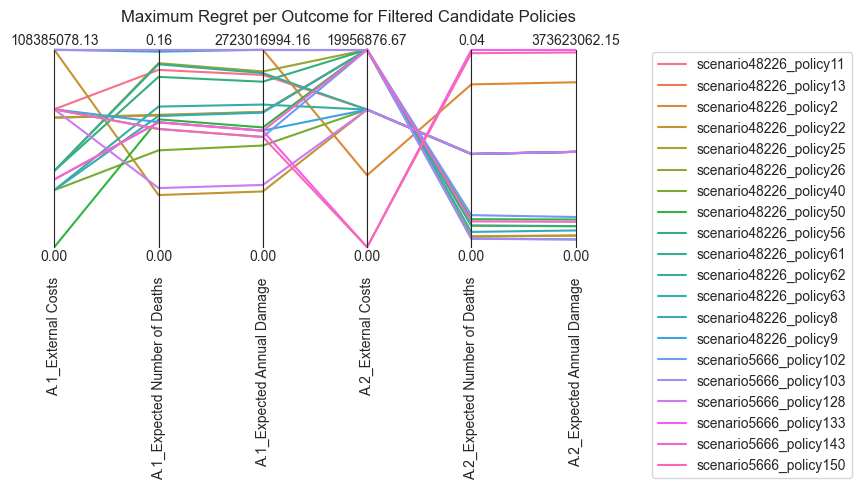

In [1020]:
all_regrets = {}
max_regret = {}

for outcome in outcomes_of_interest:
    # experiments_df = experiments_by_scenario[scenario]
    # outcomes_dict = outcomes_by_scenario[scenario]
    # Create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    # data = pd.DataFrame({
    #     outcome : df_scenario[outcome], 
    #     "policy" : df_scenario['policy'],
    #     "robustness_scenario" : df_scenario['scenario'],
    # })

    data = policies_50_results[[outcome, 'policy', 'scenario']]

    # display(data)
    # Filter out rows that are not for policies kept according to signal to noise ratio. 
    data = data[data['policy'].isin(remaining_policies)]
    # display(data)
    # Reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    all_regrets[outcome] = outcome_regret
    max_regret[outcome] = outcome_regret.max()

# Plot regret heatmap
string = str(df_scenario['scenario_original'][0])
max_regret = pd.DataFrame(max_regret)
# sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
# plt.title(f'Regret Heatmap for Policies from Scenario {string}')
# # plt.savefig('img/regret__top50_' + scenario + '_heatmap.png')
# plt.show()

# Plot regret pairplot
data = max_regret
data = data.sort_index()

limits = parcoords.get_limits(data)
limits.loc[0, outcomes_of_interest] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    colors = sns.color_palette("husl", data.shape[0])
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.title(f'Maximum Regret per Outcome for Filtered Candidate Policies', loc='right')
# plt.savefig('img/regret__top50_' + scenario + '_pairplot.png')
    
plt.show()

In [1021]:
final_policies = ['scenario48226_policy13', 'scenario48226_policy62', 'scenario5666_policy143', 'scenario5666_policy150']

In [1022]:
# Filter the selected policies
df_final = df_final.loc[final_policies]
remaining_levers = remaining_levers.loc[final_policies]
remaining_policies = df.reset_index()
remaining_policies = remaining_policies.iloc[:,0]
remaining_policies = remaining_policies.tolist()

In [1023]:
remaining_levers

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_Bmax,A.5_Brate,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_pfail,EWS_DaysToThreat,discount rate 0,discount rate 1,discount rate 2
policy,,,,,,,,,,,,,,,,,,,,,
scenario48226_policy13,NaN,NaN,1.0,NaN,NaN,1.0,1,1,1,1,...,206.280768,1.5,6.0,5.0,NaN,0.874748,3,3.5,3.5,3.5
scenario48226_policy62,NaN,1.0,NaN,NaN,NaN,NaN,1,1,1,1,...,206.280768,1.5,NaN,5.0,6.0,0.874748,3,3.5,3.5,3.5
scenario5666_policy143,1.0,NaN,NaN,NaN,NaN,NaN,1,1,1,1,...,206.280768,1.5,7.0,NaN,3.0,0.874748,4,3.5,3.5,3.5
scenario5666_policy150,NaN,NaN,1.0,NaN,1.0,NaN,1,1,1,1,...,206.280768,1.5,4.0,6.0,5.0,0.874748,3,3.5,3.5,3.5


remaining levers nog ff uitzoeken, want Gabe eindigt met paar levers, en wij met heel veel.